# Описание проекта

Вы - маркетинговый аналитик развлекательного приложения Procrastinate Pro+. Несколько прошлых месяцев развлекательного приложения Procrastinate Pro+ постоянно приносит убытки - в привлечение пользователей была вложена куча денег, а толку никакого. Нужно разобраться в причинах этой ситуации.<br>

# Описание данных

В нашем распоряжении есть лог сервера с данными о посещениях приложения новыми пользователями, зарегистрировавшимися в период с 2019-05-01 по 2019-10-27, выгрузка их покупок за этот период, а также статистика рекламных расходов. Необходимо изучить, как люди пользуются продуктом, когда они начинают покупать, сколько денег приносит каждый клиент, когда он окупается и какие факторы отрицательно влияют на привлечение пользователей.<br>

Таблица visits_log_short (лог сервера с информацией о посещениях сайта):

    User Id — уникальный идентификатор пользователя 
    Device — категория устройства пользователя
    Session start — дата и время начала сессии
    Session End — дата и время окончания сессии
    Channel — идентификатор рекламного источника, из которого пришел пользователь
    Region - страна пользователя

Таблица orders_log_short (информация о заказах):

    User Id — уникальный id пользователя, который сделал заказ
    Event Dt — дата и время покупки
    Revenue — выручка

Таблица costs_short (информация о затратах на маркетинг):

    Channel — идентификатор рекламного источника
    Dt — дата
    Costs — затраты на этот рекламный источник в этот день

## Шаг 1. Загрузка данных и подготовка к анализу

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
orders = pd.read_csv('/datasets/orders_info_short.csv', parse_dates=['Event Dt'])
visits = pd.read_csv('/datasets/visits_info_short.csv', parse_dates=['Session Start', 'Session End'])
costs = pd.read_csv('/datasets/costs_info_short.csv', parse_dates=['dt']) 

In [3]:
for i in [orders, visits, costs]:
    print(i.head())
    print(i.info())
    print('------------------------------------------------------------')

        User Id            Event Dt  Revenue
0  188246423999 2019-05-01 23:09:52     4.99
1  174361394180 2019-05-01 12:24:04     4.99
2  529610067795 2019-05-01 11:34:04     4.99
3  319939546352 2019-05-01 15:34:40     4.99
4  366000285810 2019-05-01 13:59:51     4.99
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40212 entries, 0 to 40211
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   User Id   40212 non-null  int64         
 1   Event Dt  40212 non-null  datetime64[ns]
 2   Revenue   40212 non-null  float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 942.6 KB
None
------------------------------------------------------------
        User Id         Region   Device  Channel       Session Start  \
0  981449118918  United States   iPhone  organic 2019-05-01 02:36:01   
1  278965908054  United States   iPhone  organic 2019-05-01 04:46:31   
2  590706206550  United States      Mac

In [4]:
# приведение названий столбцов к нижнему регистру. Удаление пробелов
for i in [orders, visits, costs]:
    i.columns = i.columns.str.lower()

for i in [orders, visits, costs]:
    i.columns = i.columns.str.lower().str.replace(' ', '_')

In [5]:
for i in [orders, visits, costs]:
    # поиск дубликатов
    print('Дубликатов:', i.duplicated().sum())
        
    # получение информации о количестве пропущенных значений в каждом столбце
    print('Пропущенных значений в столбцах:')
    print(i.isna().sum())
    print('-------------------------------')

Дубликатов: 0
Пропущенных значений в столбцах:
user_id     0
event_dt    0
revenue     0
dtype: int64
-------------------------------
Дубликатов: 0
Пропущенных значений в столбцах:
user_id          0
region           0
device           0
channel          0
session_start    0
session_end      0
dtype: int64
-------------------------------
Дубликатов: 0
Пропущенных значений в столбцах:
dt         0
channel    0
costs      0
dtype: int64
-------------------------------


In [6]:
# изменение типа данных в столбцах
orders['event_dt'] = pd.to_datetime(orders['event_dt'])
visits['session_start'] = pd.to_datetime(visits['session_start'])
visits['session_end'] = pd.to_datetime(visits['session_end'])
costs['dt'] = pd.to_datetime(costs['dt']).dt.date 

In [7]:
# просмотр уникальных значений в категориальных данных
for i in [visits['region'], visits['device'], visits['channel'], costs['channel']]:
    print(i.unique())
    print('-----------------------------------------------------')

['United States' 'UK' 'France' 'Germany']
-----------------------------------------------------
['iPhone' 'Mac' 'Android' 'PC']
-----------------------------------------------------
['organic' 'TipTop' 'RocketSuperAds' 'YRabbit' 'FaceBoom' 'MediaTornado'
 'AdNonSense' 'LeapBob' 'WahooNetBanner' 'OppleCreativeMedia'
 'lambdaMediaAds']
-----------------------------------------------------
['FaceBoom' 'MediaTornado' 'RocketSuperAds' 'TipTop' 'YRabbit'
 'AdNonSense' 'LeapBob' 'OppleCreativeMedia' 'WahooNetBanner'
 'lambdaMediaAds']
-----------------------------------------------------


Названия столбцов приведены в нижний регистр, пробелы заменены на подчеркивание.<br>
Дубликатов нет.<br>
Пропусков нет.<br>
Столбцы с датами переведены в тип дат.<br>
Категориальные данные в порядке.

## Шаг 2. Функции для расчета и анализа LTV, ROI, удержания и конверсии

In [8]:
# функция для создания пользовательских профилей

def get_profiles(sessions, orders, ad_costs):

    # находим параметры первых посещений
    profiles = (
        sessions.sort_values(by=['user_id', 'session_start'])
        .groupby('user_id')
        .agg(
            {
                'session_start': 'first',
                'channel': 'first',
                'device': 'first',
                'region': 'first',
            }
        )
        .rename(columns={'session_start': 'first_ts'})
        .reset_index()
    )

    # для когортного анализа определяем дату первого посещения
    # и первый день месяца, в который это посещение произошло
    profiles['dt'] = profiles['first_ts'].dt.date
    profiles['month'] = profiles['first_ts'].astype('datetime64[M]')

    # добавляем признак платящих пользователей
    profiles['payer'] = profiles['user_id'].isin(orders['user_id'].unique())

    # считаем количество уникальных пользователей
    # с одинаковыми источником и датой привлечения
    new_users = (
        profiles.groupby(['dt', 'channel'])
        .agg({'user_id': 'nunique'})
        .rename(columns={'user_id': 'unique_users'})
        .reset_index()
    )

    # объединяем траты на рекламу и число привлечённых пользователей
    ad_costs = ad_costs.merge(new_users, on=['dt', 'channel'], how='left')

    # делим рекламные расходы на число привлечённых пользователей
    ad_costs['acquisition_cost'] = ad_costs['costs'] / ad_costs['unique_users']

    # добавляем стоимость привлечения в профили
    profiles = profiles.merge(
        ad_costs[['dt', 'channel', 'acquisition_cost']],
        on=['dt', 'channel'],
        how='left',
    )

    # стоимость привлечения органических пользователей равна нулю
    profiles['acquisition_cost'] = profiles['acquisition_cost'].fillna(0)

    return profiles

In [9]:
def get_retention(
    profiles,
    sessions,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # добавляем столбец payer в передаваемый dimensions список
    dimensions = ['payer'] + dimensions

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # собираем «сырые» данные для расчёта удержания
    result_raw = result_raw.merge(
        sessions[['user_id', 'session_start']], on='user_id', how='left'
    )
    result_raw['lifetime'] = (
        result_raw['session_start'] - result_raw['first_ts']
    ).dt.days

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу удержания
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # получаем таблицу динамики удержания
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [10]:
# функция для расчёта конверсии

def get_conversion(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')

    # определяем дату и время первой покупки для каждого пользователя
    first_purchases = (
        purchases.sort_values(by=['user_id', 'event_dt'])
        .groupby('user_id')
        .agg({'event_dt': 'first'})
        .reset_index()
    )

    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        first_purchases[['user_id', 'event_dt']], on='user_id', how='left'
    )

    # рассчитываем лайфтайм для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days

    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users' 
        dimensions = dimensions + ['cohort']

    # функция для группировки таблицы по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        result = df.pivot_table(
            index=dims, columns='lifetime', values='user_id', aggfunc='nunique'
        )
        result = result.fillna(0).cumsum(axis = 1)
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # делим каждую «ячейку» в строке на размер когорты
        # и получаем conversion rate
        result = result.div(result['cohort_size'], axis=0)
        result = result[['cohort_size'] + list(range(horizon_days))]
        result['cohort_size'] = cohort_sizes
        return result

    # получаем таблицу конверсии
    result_grouped = group_by_dimensions(result_raw, dimensions, horizon_days)

    # для таблицы динамики конверсии убираем 'cohort' из dimensions
    if 'cohort' in dimensions: 
        dimensions = []

    # получаем таблицу динамики конверсии
    result_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    # возвращаем обе таблицы и сырые данные
    return result_raw, result_grouped, result_in_time 

In [11]:
# функция для расчёта LTV и ROI

def get_ltv(
    profiles,
    purchases,
    observation_date,
    horizon_days,
    dimensions=[],
    ignore_horizon=False,
):

    # исключаем пользователей, не «доживших» до горизонта анализа
    last_suitable_acquisition_date = observation_date
    if not ignore_horizon:
        last_suitable_acquisition_date = observation_date - timedelta(
            days=horizon_days - 1
        )
    result_raw = profiles.query('dt <= @last_suitable_acquisition_date')
    # добавляем данные о покупках в профили
    result_raw = result_raw.merge(
        purchases[['user_id', 'event_dt', 'revenue']], on='user_id', how='left'
    )
    # рассчитываем лайфтайм пользователя для каждой покупки
    result_raw['lifetime'] = (
        result_raw['event_dt'] - result_raw['first_ts']
    ).dt.days
    # группируем по cohort, если в dimensions ничего нет
    if len(dimensions) == 0:
        result_raw['cohort'] = 'All users'
        dimensions = dimensions + ['cohort']

    # функция группировки по желаемым признакам
    def group_by_dimensions(df, dims, horizon_days):
        # строим «треугольную» таблицу выручки
        result = df.pivot_table(
            index=dims, columns='lifetime', values='revenue', aggfunc='sum'
        )
        # находим сумму выручки с накоплением
        result = result.fillna(0).cumsum(axis=1)
        # вычисляем размеры когорт
        cohort_sizes = (
            df.groupby(dims)
            .agg({'user_id': 'nunique'})
            .rename(columns={'user_id': 'cohort_size'})
        )
        # объединяем размеры когорт и таблицу выручки
        result = cohort_sizes.merge(result, on=dims, how='left').fillna(0)
        # считаем LTV: делим каждую «ячейку» в строке на размер когорты
        result = result.div(result['cohort_size'], axis=0)
        # исключаем все лайфтаймы, превышающие горизонт анализа
        result = result[['cohort_size'] + list(range(horizon_days))]
        # восстанавливаем размеры когорт
        result['cohort_size'] = cohort_sizes

        # собираем датафрейм с данными пользователей и значениями CAC, 
        # добавляя параметры из dimensions
        cac = df[['user_id', 'acquisition_cost'] + dims].drop_duplicates()

        # считаем средний CAC по параметрам из dimensions
        cac = (
            cac.groupby(dims)
            .agg({'acquisition_cost': 'mean'})
            .rename(columns={'acquisition_cost': 'cac'})
        )

        # считаем ROI: делим LTV на CAC
        roi = result.div(cac['cac'], axis=0)

        # удаляем строки с бесконечным ROI
        roi = roi[~roi['cohort_size'].isin([np.inf])]

        # восстанавливаем размеры когорт в таблице ROI
        roi['cohort_size'] = cohort_sizes

        # добавляем CAC в таблицу ROI
        roi['cac'] = cac['cac']

        # в финальной таблице оставляем размеры когорт, CAC
        # и ROI в лайфтаймы, не превышающие горизонт анализа
        roi = roi[['cohort_size', 'cac'] + list(range(horizon_days))]

        # возвращаем таблицы LTV и ROI
        return result, roi

    # получаем таблицы LTV и ROI
    result_grouped, roi_grouped = group_by_dimensions(
        result_raw, dimensions, horizon_days
    )

    # для таблиц динамики убираем 'cohort' из dimensions
    if 'cohort' in dimensions:
        dimensions = []

    # получаем таблицы динамики LTV и ROI
    result_in_time, roi_in_time = group_by_dimensions(
        result_raw, dimensions + ['dt'], horizon_days
    )

    return (
        result_raw,  # сырые данные
        result_grouped,  # таблица LTV
        result_in_time,  # таблица динамики LTV
        roi_grouped,  # таблица ROI
        roi_in_time,  # таблица динамики ROI
    ) 

In [12]:
# функция для сглаживания фрейма

def filter_data(df, window):
    # для каждого столбца применяем скользящее среднее
    for column in df.columns.values:
        df[column] = df[column].rolling(window).mean() 
    return df

In [39]:
# функция для визуализации удержания

def plot_retention(retention, retention_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 10))

    # исключаем размеры когорт и удержание первого дня
    retention = retention.drop(columns=['cohort_size', 0])
    # в таблице динамики оставляем только нужный лайфтайм
    retention_history = retention_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # если в индексах таблицы удержания только payer,
    # добавляем второй признак — cohort
    if retention.index.nlevels == 1:
        retention['cohort'] = 'All users'
        retention = retention.reset_index().set_index(['cohort', 'payer'])

    # в таблице графиков — два столбца и две строки, четыре ячейки
    # в первой строим кривые удержания платящих пользователей
    ax1 = plt.subplot(2, 2, 1)
    retention.query('payer == True').droplevel('payer').T.plot(
        grid=True, ax=ax1, fontsize = 20
    )
    plt.legend()
    plt.xlabel('Лайфтайм', fontsize = 15, fontweight='bold')
    plt.title('Удержание платящих пользователей', fontsize = 15, fontweight='bold')

    # во второй ячейке строим кривые удержания неплатящих
    # вертикальная ось — от графика из первой ячейки
    ax2 = plt.subplot(2, 2, 2, sharey=ax1)
    retention.query('payer == False').droplevel('payer').T.plot(
        grid=True, fontsize = 20, ax=ax2
    )
    plt.legend()
    plt.xlabel('Лайфтайм', fontsize = 15, fontweight='bold')
    plt.title('Удержание неплатящих пользователей', fontsize = 15, fontweight='bold')

    # в третьей ячейке — динамика удержания платящих
    ax3 = plt.subplot(2, 2, 3)
    # получаем названия столбцов для сводной таблицы
    columns = [
        name
        for name in retention_history.index.names
        if name not in ['dt', 'payer']
    ]
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == True').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, fontsize = 20, ax=ax3)
    plt.xlabel('Дата привлечения', fontsize = 15, fontweight='bold')
    plt.title(
        'Динамика удержания платящих пользователей на {}-й день'.format(
            horizon, fontsize = 10, fontweight='bold'
        )
    )

    # в чётвертой ячейке — динамика удержания неплатящих
    ax4 = plt.subplot(2, 2, 4, sharey=ax3)
    # фильтруем данные и строим график
    filtered_data = retention_history.query('payer == False').pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, fontsize = 20, ax=ax4)
    plt.xlabel('Дата привлечения', fontsize = 15, fontweight='bold')
    plt.title(
        'Динамика удержания неплатящих пользователей на {}-й день'.format(
            horizon, fontsize = 15, fontweight='bold'
        )
    )
    
    plt.tight_layout()
    plt.show() 

In [38]:
# функция для визуализации конверсии

def plot_conversion(conversion, conversion_history, horizon, window=7):

    # задаём размер сетки для графиков
    plt.figure(figsize=(15, 5))

    # исключаем размеры когорт
    conversion = conversion.drop(columns=['cohort_size'])
    # в таблице динамики оставляем только нужный лайфтайм
    conversion_history = conversion_history.drop(columns=['cohort_size'])[
        [horizon - 1]
    ]

    # первый график — кривые конверсии
    ax1 = plt.subplot(1, 2, 1)
    conversion.T.plot(grid=True, fontsize = 20, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм', fontsize = 15, fontweight='bold')
    plt.title('Конверсия пользователей', fontsize = 15, fontweight='bold')

    # второй график — динамика конверсии
    ax2 = plt.subplot(1, 2, 2, sharey=ax1)
    columns = [
        # столбцами сводной таблицы станут все столбцы индекса, кроме даты
        name for name in conversion_history.index.names if name not in ['dt']
    ]
    filtered_data = conversion_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, fontsize = 20, ax=ax2)
    plt.xlabel('Дата привлечения', fontsize = 15, fontweight='bold')
    plt.title('Динамика конверсии пользователей на {}-й день'.format(horizon), fontsize = 15, fontweight='bold')

    plt.tight_layout()
    plt.show() 

In [49]:
# функция для визуализации LTV и ROI

def plot_ltv_roi(ltv, ltv_history, roi, roi_history, horizon, window=7):

    # задаём сетку отрисовки графиков
    plt.figure(figsize=(20, 10))

    # из таблицы ltv исключаем размеры когорт
    ltv = ltv.drop(columns=['cohort_size'])
    # в таблице динамики ltv оставляем только нужный лайфтайм
    ltv_history = ltv_history.drop(columns=['cohort_size'])[[horizon - 1]]

    # стоимость привлечения запишем в отдельный фрейм
    cac_history = roi_history[['cac']]

    # из таблицы roi исключаем размеры когорт и cac
    roi = roi.drop(columns=['cohort_size', 'cac'])
    # в таблице динамики roi оставляем только нужный лайфтайм
    roi_history = roi_history.drop(columns=['cohort_size', 'cac'])[
        [horizon - 1]
    ]

    # первый график — кривые ltv
    ax1 = plt.subplot(2, 3, 1)
    ltv.T.plot(grid=True, fontsize = 20, ax=ax1)
    plt.legend()
    plt.xlabel('Лайфтайм', fontsize = 15, fontweight='bold')
    plt.title('LTV', fontsize = 15, fontweight='bold')

    # второй график — динамика ltv
    ax2 = plt.subplot(2, 3, 2, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in ltv_history.index.names if name not in ['dt']]
    filtered_data = ltv_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, fontsize = 15, ax=ax2)
    plt.xlabel('Дата привлечения', fontsize = 15, fontweight='bold')
    plt.title('Динамика LTV пользователей на {}-й день'.format(horizon), fontsize = 15, fontweight='bold')

    # третий график — динамика cac
    ax3 = plt.subplot(2, 3, 3, sharey=ax1)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in cac_history.index.names if name not in ['dt']]
    filtered_data = cac_history.pivot_table(
        index='dt', columns=columns, values='cac', aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, fontsize = 15, ax=ax3)
    plt.xlabel('Дата привлечения', fontsize = 15, fontweight='bold')
    plt.title('Динамика стоимости привлечения пользователей', fontsize = 15, fontweight='bold')

    # четвёртый график — кривые roi
    ax4 = plt.subplot(2, 3, 4)
    roi.T.plot(grid=True, fontsize = 20, ax=ax4)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.legend()
    plt.xlabel('Лайфтайм', fontsize = 15, fontweight='bold')
    plt.title('ROI', fontsize = 15, fontweight='bold')

    # пятый график — динамика roi
    ax5 = plt.subplot(2, 3, 5, sharey=ax4)
    # столбцами сводной таблицы станут все столбцы индекса, кроме даты
    columns = [name for name in roi_history.index.names if name not in ['dt']]
    filtered_data = roi_history.pivot_table(
        index='dt', columns=columns, values=horizon - 1, aggfunc='mean'
    )
    filter_data(filtered_data, window).plot(grid=True, fontsize = 15, ax=ax5)
    plt.axhline(y=1, color='red', linestyle='--', label='Уровень окупаемости')
    plt.xlabel('Дата привлечения', fontsize = 15, fontweight='bold')
    plt.title('Динамика ROI пользователей на {}-й день'.format(horizon), fontsize = 15, fontweight='bold')

    plt.tight_layout()
    plt.show() 

In [16]:
# установим момент и горизонт анализа
observation_date = datetime(2019, 11, 1).date()  
horizon_days = 14  

## Шаг 3. Исследовательский анализ данных

Необходимо:
- Построить профили пользователей. 
- Определить минимальную и максимальную дату привлечения пользователей.
- Из каких стран приходят посетители? Какие страны дают больше всего платящих пользователей?
- Какими устройствами они пользуются? С каких устройств чаще всего заходят платящие пользователи?
- По каким рекламным каналам шло привлечение пользователей? Какие каналы приносят больше всего платящих пользователей?

In [17]:
# получаем профили пользователей
profiles = get_profiles(visits, orders, costs)
profiles.head(5)

,user_id,first_ts,channel,device,region,dt,month,payer,acquisition_cost
0,599326,2019-05-07 20:58:57,FaceBoom,Mac,United States,2019-05-07,2019-05-01,True,1.088172
1,4919697,2019-07-09 12:46:07,FaceBoom,iPhone,United States,2019-07-09,2019-07-01,False,1.107237
2,6085896,2019-10-01 09:58:33,organic,iPhone,France,2019-10-01,2019-10-01,False,0.000000
3,22593348,2019-08-22 21:35:48,AdNonSense,PC,Germany,2019-08-22,2019-08-01,False,0.988235
4,31989216,2019-10-02 00:07:44,YRabbit,iPhone,United States,2019-10-02,2019-10-01,False,0.230769


In [18]:
# минимальная дата привлечения пользователей
first_prof_date = profiles.first_ts.min()
print('Минимальная дата привлечения пользователей:', first_prof_date)

# максимальная дата привлечения пользователей
last_prof_date = profiles.first_ts.max()
print('Максимальная дата привлечения пользователей:', last_prof_date)

Минимальная дата привлечения пользователей: 2019-05-01 00:00:41
Максимальная дата привлечения пользователей: 2019-10-27 23:59:04


In [19]:
# считаем количество платящих пользователей по странам
payer_by_country = profiles.groupby('region').agg({'user_id': 'nunique', 'payer': 'sum'}).sort_values(by='user_id', ascending=False)
payer_by_country['id_persent'] = round(payer_by_country['user_id'] / payer_by_country['user_id'].sum() * 100, 2)
payer_by_country['payer_persent'] = round(payer_by_country['payer'] / payer_by_country['payer'].sum() * 100, 2)
payer_by_country['payer_by_user_persent'] = round(payer_by_country['payer'] / payer_by_country['user_id'] * 100, 2) 
display('Количество платящих пользователей по странам', payer_by_country)

'Количество платящих пользователей по странам'

,user_id,payer,id_persent,payer_persent,payer_by_user_persent
region,,,,,
United States,100002,6902,66.66,77.72,6.90
UK,17575,700,11.72,7.88,3.98
France,17450,663,11.63,7.47,3.80
Germany,14981,616,9.99,6.94,4.11


In [20]:
# считаем количество платящих пользователей по используемым устройствам
payer_by_device = profiles.groupby('device').agg({'user_id': 'nunique', 'payer': 'sum'}).sort_values(by='user_id', ascending=False)
payer_by_device['id_persent'] = round(payer_by_device['user_id'] / payer_by_device['user_id'].sum() * 100 , 2)
payer_by_device['payer_persent'] = round(payer_by_device['payer'] / payer_by_device['payer'].sum() * 100 , 2)
payer_by_device['payer_by_user_persent'] = round(payer_by_device['payer'] / payer_by_device['user_id'] * 100 , 2)
display('Количество платящих пользователей по используемым устройствам', payer_by_device)

'Количество платящих пользователей по используемым устройствам'

,user_id,payer,id_persent,payer_persent,payer_by_user_persent
device,,,,,
iPhone,54479,3382,36.32,38.08,6.21
Android,35032,2050,23.35,23.08,5.85
PC,30455,1537,20.30,17.31,5.05
Mac,30042,1912,20.03,21.53,6.36


In [21]:
# считаем количество платящих пользователей по рекламным каналам
payer_by_channel = profiles.groupby('channel').agg({'user_id': 'nunique', 
                                                    'payer': 'sum'}).sort_values(by='user_id', ascending=False)
payer_by_channel['id_persent'] = round(payer_by_channel['user_id'] / payer_by_channel['user_id'].sum() * 100 , 2)
payer_by_channel['payer_persent'] = round(payer_by_channel['payer'] / payer_by_channel['payer'].sum() * 100 , 2)
payer_by_channel['payer_by_user_persent'] = round(payer_by_channel['payer'] / payer_by_channel['user_id'] * 100 , 2)
display('Количество платящих пользователей по рекламным каналам', payer_by_channel)

'Количество платящих пользователей по рекламным каналам'

,user_id,payer,id_persent,payer_persent,payer_by_user_persent
channel,,,,,
organic,56439,1160,37.62,13.06,2.06
FaceBoom,29144,3557,19.43,40.05,12.20
TipTop,19561,1878,13.04,21.15,9.60
OppleCreativeMedia,8605,233,5.74,2.62,2.71
LeapBob,8553,262,5.70,2.95,3.06
WahooNetBanner,8553,453,5.70,5.10,5.30
RocketSuperAds,4448,352,2.97,3.96,7.91
MediaTornado,4364,156,2.91,1.76,3.57
YRabbit,4312,165,2.87,1.86,3.83


Минимальной и максимальной датой привлечения пользователей являются 1 мая и 27 октября 2019 года соответственно.<br>
Больше всего пользователей приходит из США. Не смотря на то, что совершили покупки всего 6,9% американцев от общего числа покупателей, это 77% тех кто совершил покупки. И 66% тех кто зарегистрировался.<br>
По количеству заплативших больше всего пришло с iPhone. Android на втором месте. 36% и 23% с них зарегистрировались от числа всех зарегистрированных пользователей. И 38% и 23% соответственно совершили покупки от числа всех покупок.<br>
Не смотря на то, что больше всего пользователей именно органичестких. Процент покупок у них ниже чем у FaceBoom	и TipTop. 13% против 40% и 21% соответственно. А процент заплативших от количества зарегистрировавшихся соответственно 2% у органических, 12% у FaceBoom и 9% у TipTop. <br>
Так же среди рекламных каналов надо отметить AdNonSense и lambdaMediaAds. По количеству зарегистрировавшихся пользователей они самые малые. Но процент тех кто заплатил довольно высок - 11% и 10% соответственно.<br>
На основе этих данным можно сделать портрет покупателя: американец с новым айфоном с FaceBoom или c TipTop. 

## Шаг 4. Маркетинг

Необходимо выяснить:
- Сколько денег потратили? Всего / на каждый источник / по времени
- Сколько в среднем стоило привлечение одного покупателя из каждого источника?

In [22]:
# извлекаем из даты месяц в отдельный столбец
costs['month'] = pd.DatetimeIndex(costs['dt']).month

# извлекаем из даты неделю в отдельный столбец
costs['week'] = pd.DatetimeIndex(costs['dt']).week

In [23]:
# сколько всего потратили денег на рекламу
print('Всего потрачено на рекламу:', costs['costs'].sum())

# сколько на каждый источник потратили денег на рекламу
costs_by_channel = costs.groupby('channel').agg({'costs': 'sum'}).sort_values(by='costs', ascending=False).reset_index()
costs_by_channel['costs_persent'] = round(costs_by_channel['costs'] / costs_by_channel['costs'].sum() * 100 , 2)
display('На каждый источник рекламы было потрачено:', costs_by_channel)

# сколько потратили денег на рекламу в месяц
costs_by_month = costs.groupby('month').agg({'costs': 'sum'}).sort_values(by='month', ascending=True)
costs_by_month['costs_persent'] = round(costs_by_month['costs'] / costs_by_month['costs'].sum() * 100 ,2)
display('На рекламу в месяц было потрачено:', costs_by_month)

# сколько потратили денег на рекламу в неделю
costs_by_week = costs.groupby('week').agg({'costs': 'sum'}).sort_values(by='week', ascending=True)
costs_by_week['costs_persent'] = round(costs_by_week['costs'] / costs_by_week['costs'].sum() * 100 , 2)
display('На рекламу в неделю было потрачено:', costs_by_week)

Всего потрачено на рекламу: 105497.30000000002


'На каждый источник рекламы было потрачено:'

,channel,costs,costs_persent
0,TipTop,54751.30,51.90
1,FaceBoom,32445.60,30.75
2,WahooNetBanner,5151.00,4.88
3,AdNonSense,3911.25,3.71
4,OppleCreativeMedia,2151.25,2.04
5,RocketSuperAds,1833.00,1.74
6,LeapBob,1797.60,1.70
7,lambdaMediaAds,1557.60,1.48
8,MediaTornado,954.48,0.90
9,YRabbit,944.22,0.90


'На рекламу в месяц было потрачено:'

,costs,costs_persent
month,,
5,9978.570,9.46
6,15090.045,14.30
7,16447.060,15.59
8,20657.870,19.58
9,22441.340,21.27
10,20882.415,19.79


'На рекламу в неделю было потрачено:'

,costs,costs_persent
week,,
18,1455.640,1.38
19,2031.820,1.93
20,1976.320,1.87
21,2297.120,2.18
22,3427.075,3.25
23,2915.740,2.76
24,2706.390,2.57
25,3421.390,3.24
26,4837.120,4.59


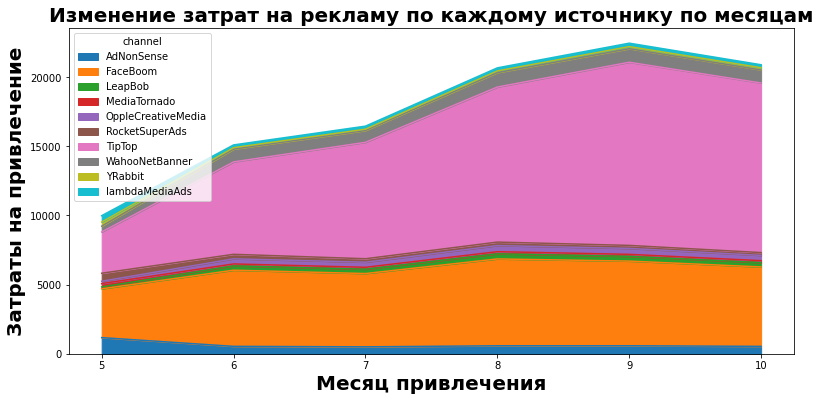

In [24]:
# изменение затрат на рекламу по каждому источнику по месяцам
costs.pivot_table(index = 'month', columns = 'channel', values = 'costs', aggfunc = 'sum').plot.area(figsize=(13, 6))
plt.xlabel('Месяц привлечения', fontsize=20, fontweight='bold')
plt.ylabel('Затраты на привлечение', fontsize=20, fontweight='bold')
plt.title('Изменение затрат на рекламу по каждому источнику по месяцам', fontsize=20, fontweight='bold')
plt.show() 

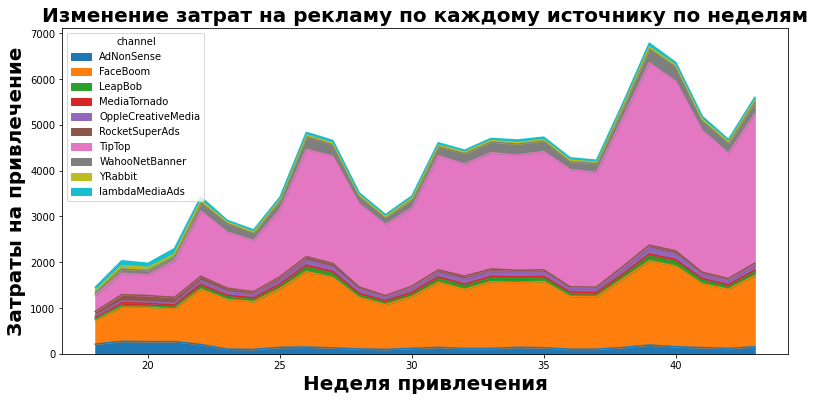

In [25]:
# изменение затрат на рекламу по каждому источнику по неделям
#plt.subplots(figsize = (12, 8))
costs.pivot_table(index = 'week', columns = 'channel', values = 'costs', aggfunc = 'sum').plot.area(figsize = (13, 6))

plt.xlabel('Неделя привлечения', fontsize=20, fontweight='bold')
plt.ylabel('Затраты на привлечение', fontsize=20, fontweight='bold')
plt.title('Изменение затрат на рекламу по каждому источнику по неделям', fontsize=20, fontweight='bold')
plt.show() 

In [26]:
# средняя стоимость привлечения одного пользователя (CAC) из каждого источника 
# посчитано по пользователям в целом и по только платящим пользователям
p_c_by_channel = costs_by_channel.merge(payer_by_channel, on='channel')
p_c_by_channel['payer_costs'] = round(p_c_by_channel['costs'] / p_c_by_channel['payer'], 2)
p_c_by_channel['id_costs'] = round(p_c_by_channel['costs'] / p_c_by_channel['user_id'], 2)

# средняя стоимость привлечения одного пользователя 
print('Средняя стоимость привлечения одного пользователя состовляет:', 
      round(p_c_by_channel['costs'].sum() / p_c_by_channel['user_id'].sum(), 2))

# средняя стоимость привлечения одного заплатившего пользователя 
print('Средняя стоимость привлечения одного заплатившего пользователя состовляет:', 
      round(p_c_by_channel['costs'].sum() / p_c_by_channel['payer'].sum(), 2))

p_c_by_channel = p_c_by_channel.rename({'channel': 'Название канала',
                                        'costs': 'Затраты',
                                        'costs_persent': 'Затраты в %',
                                        'user_id': 'Кол-во пользователей',
                                        'payer': 'Кол-во заплативших польз.',
                                        'id_persent': '% пользователей',
                                        'payer_persent': '% заплативших польз.',
                                        'payer_by_user_persent': '% заплативших от не плативших',
                                        'payer_costs': 'Ст-ть одного запл. польз.',
                                        'id_costs': 'Ст-ть одного польз.'}, axis='columns')
display(p_c_by_channel)

Средняя стоимость привлечения одного пользователя состовляет: 1.13
Средняя стоимость привлечения одного заплатившего пользователя состовляет: 13.66


,Название канала,Затраты,Затраты в %,Кол-во пользователей,Кол-во заплативших польз.,% пользователей,% заплативших польз.,% заплативших от не плативших,Ст-ть одного запл. польз.,Ст-ть одного польз.
0,TipTop,54751.30,51.90,19561,1878,13.04,21.15,9.60,29.15,2.80
1,FaceBoom,32445.60,30.75,29144,3557,19.43,40.05,12.20,9.12,1.11
2,WahooNetBanner,5151.00,4.88,8553,453,5.70,5.10,5.30,11.37,0.60
3,AdNonSense,3911.25,3.71,3880,440,2.59,4.95,11.34,8.89,1.01
4,OppleCreativeMedia,2151.25,2.04,8605,233,5.74,2.62,2.71,9.23,0.25
5,RocketSuperAds,1833.00,1.74,4448,352,2.97,3.96,7.91,5.21,0.41
6,LeapBob,1797.60,1.70,8553,262,5.70,2.95,3.06,6.86,0.21
7,lambdaMediaAds,1557.60,1.48,2149,225,1.43,2.53,10.47,6.92,0.72
8,MediaTornado,954.48,0.90,4364,156,2.91,1.76,3.57,6.12,0.22
9,YRabbit,944.22,0.90,4312,165,2.87,1.86,3.83,5.72,0.22


Всего на рекламу было потрачено 105497. Из них на TipTop и FaceBoom пришлось 51% и 30% соответственно.<br>
Затраты на рекламу были неравномерны. Шли по наростающей с мая по сентябрь. Возможно в октябре затрат больше чем в сентябре. в разбивке затрат по неделям это так же видно. У нас данные только до 27 октября. 44-й недели у нас нет.<br>
Стоимость привлечения одного заплатившего пользователя в 12 раз больше чем стоимость привлечения зарегистрировавшихся пользователей. <br>
Дороже всех обошлись пользователи с FaceBoom.

## Шаг 5. Оценка окупаемости рекламы для привлечения пользователей

С помощью LTV и ROI необходимо:
- Проанализировать общую окупаемость рекламы;
- Проанализировать окупаемость рекламы с разбивкой по устройствам;
- Проанализировать окупаемость рекламы с разбивкой по странам;
- Проанализировать окупаемость рекламы с разбивкой по рекламным каналам.

Надо ответить на вопросы:
- Окупается ли реклама, направленная на привлечение пользователей в целом? 
- Какие устройства, страны и рекламные каналы могут оказывать негативное влияние на окупаемость рекламы?
- Чем могут быть вызваны проблемы окупаемости? Изучение конверсии и удержания с разбивкой по устройствам, странам, рекламным каналам.

### Анализ общей окупаемости рекламы

Уникальные значения в профилях пользователей: ['FaceBoom' 'AdNonSense' 'YRabbit' 'MediaTornado' 'RocketSuperAds'
 'LeapBob' 'TipTop' 'WahooNetBanner' 'OppleCreativeMedia' 'lambdaMediaAds']
-----------------------------------------------------------------------------------------------


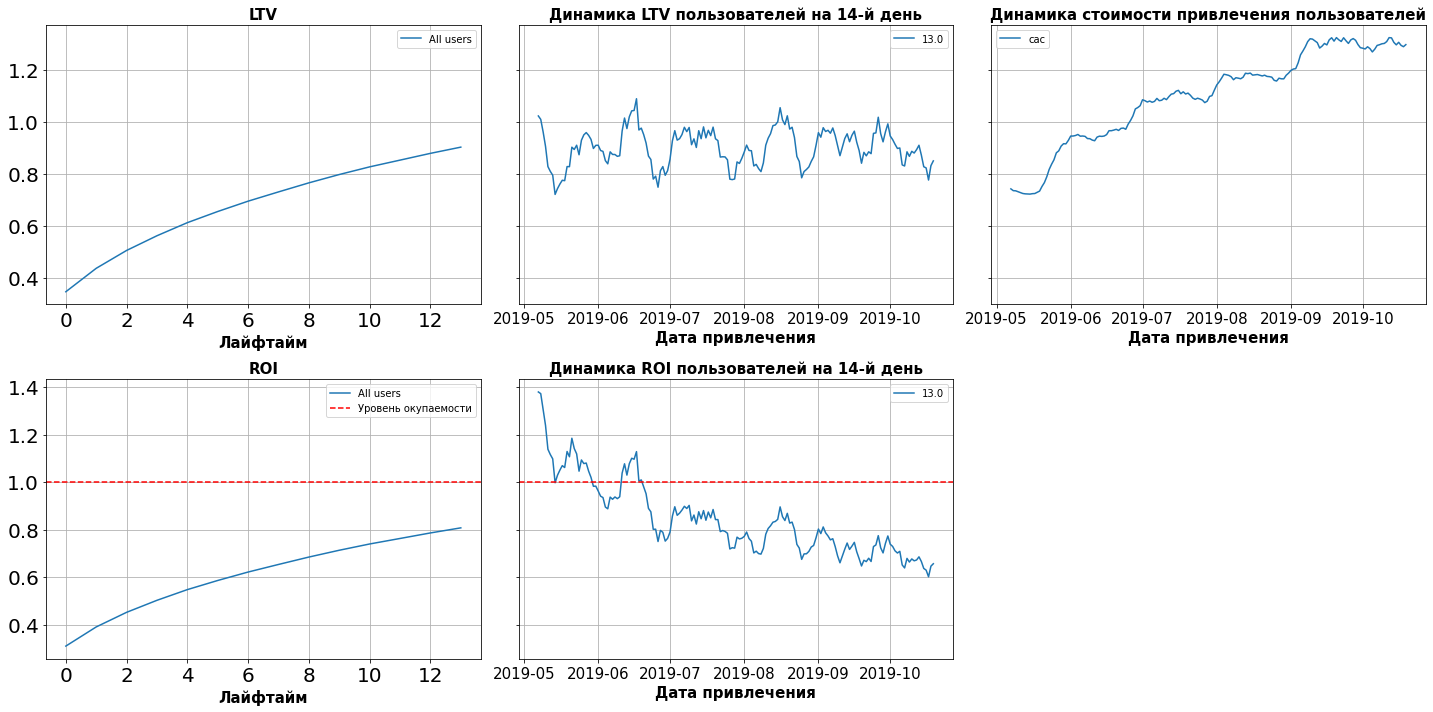

In [50]:
# исключаем органических пользователей
profiles = profiles[profiles['channel'] != 'organic']
print('Уникальные значения в профилях пользователей:', profiles['channel'].unique())
print('-----------------------------------------------------------------------------------------------')

# считаем LTV и ROI
ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days)

# строим графики
plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days) 

Окупаемость рекламы на 14-й день на уровне ниже 80% Это очень плохо!<br>
Стоимость привлечения пользователей с мая значительно возрасла. В конце весны ROI опустился до уровня окупаемости. С середины июня затраты на рекламу больше чем отдача от неё. Фирма тратила все больше, а результат был все хуже.

### Анализ окупаемости рекламы с разбивкой по устройствам

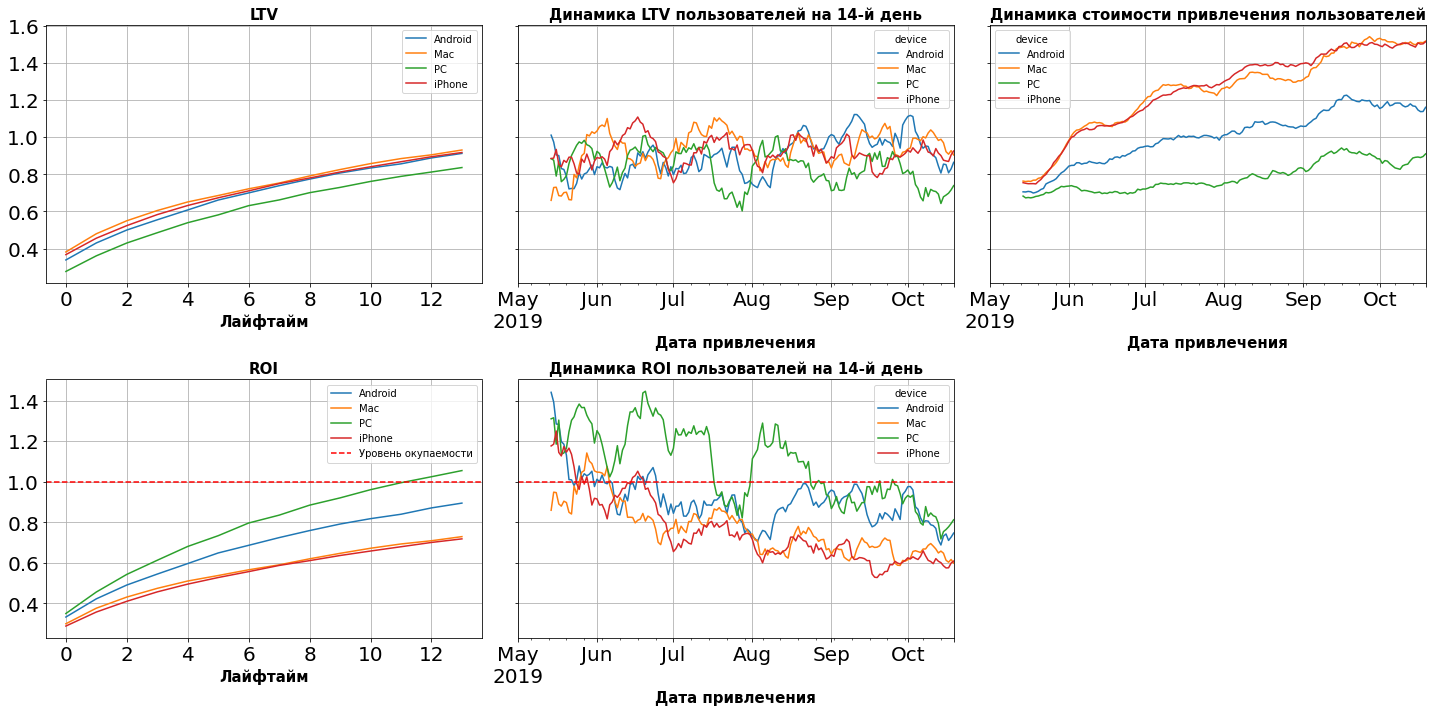

In [41]:
# смотрим окупаемость с разбивкой по устройствам
dimensions = ['device']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14) 

ROI по всем устройствам довольно низкие. Если пользователи PC ещё куда ни шло держатся, то остальные за 14 дней не окупаются.
Затраты на РС растут не так сильно как на остальные устройства. Окупаемость происходит на 11-й день. Но и тут не все хорошо. С конца августа ROI на всех платформах ниже себестоимости.

### Анализ окупаемости рекламы с разбивкой по странам

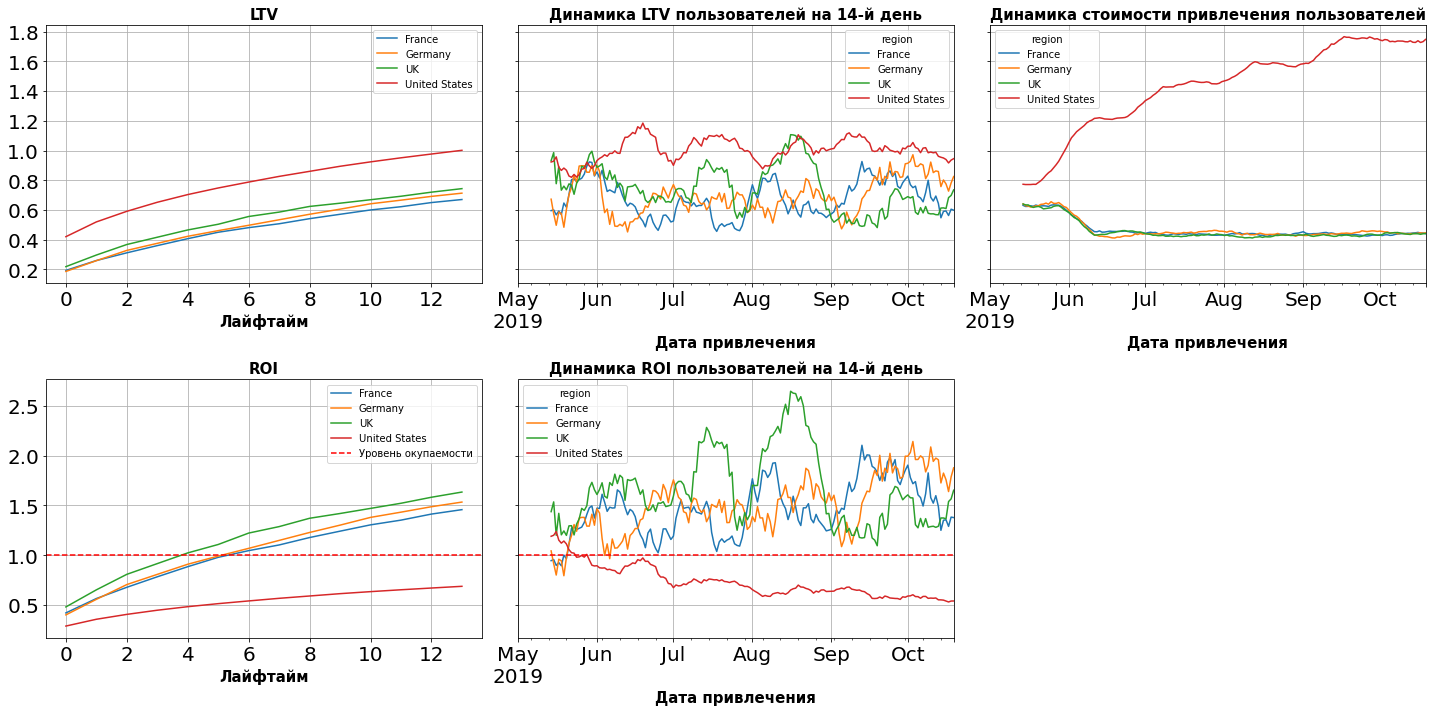

In [42]:
# смотрим окупаемость с разбивкой по странам
dimensions = ['region']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14) 

Занимая две трети рынка американские пользователи тянут вниз всю рекламу. На 14-й день пользователи США не окупаются. <br>
По остальным странам ситуация стабильно хорошая. Со второго по четвертый день ROI выходит на окупаемость.

### Анализ окупаемости рекламы с разбивкой по рекламным каналам

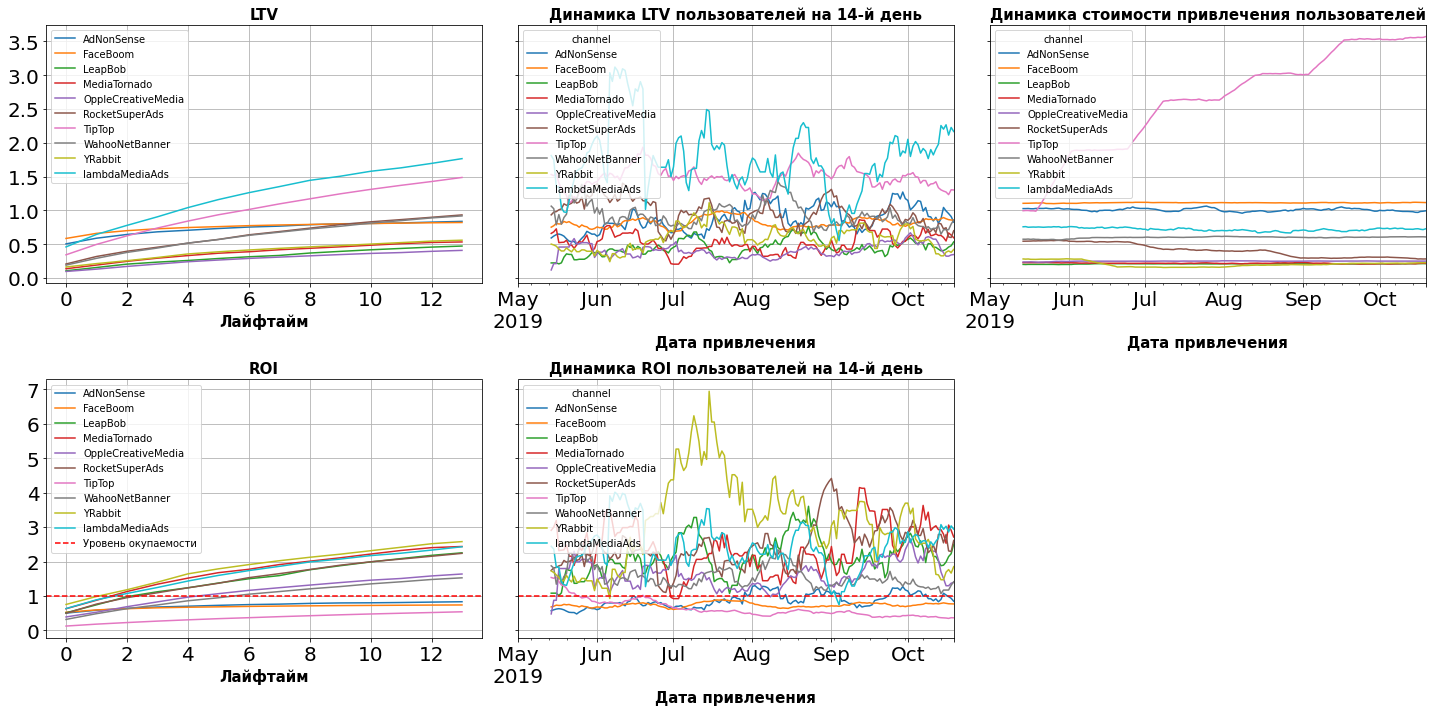

In [43]:
# смотрим окупаемость с разбивкой по источникам привлечения
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14) 

По графику Динамики стоимости привлечения пользователей видно, что дороже всего TipTop. На втором месте FaceBoom.<br>
По графику ROI видно, что TipTop и FaceBoom не окупаются за 14 дней.

### Построение и анализ графиков конверсии и удержания с разбивкой по устройствам, странам, рекламным каналам.

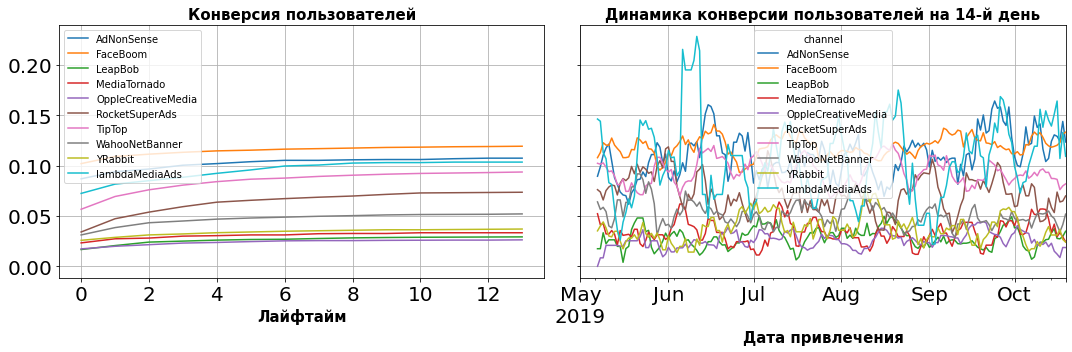

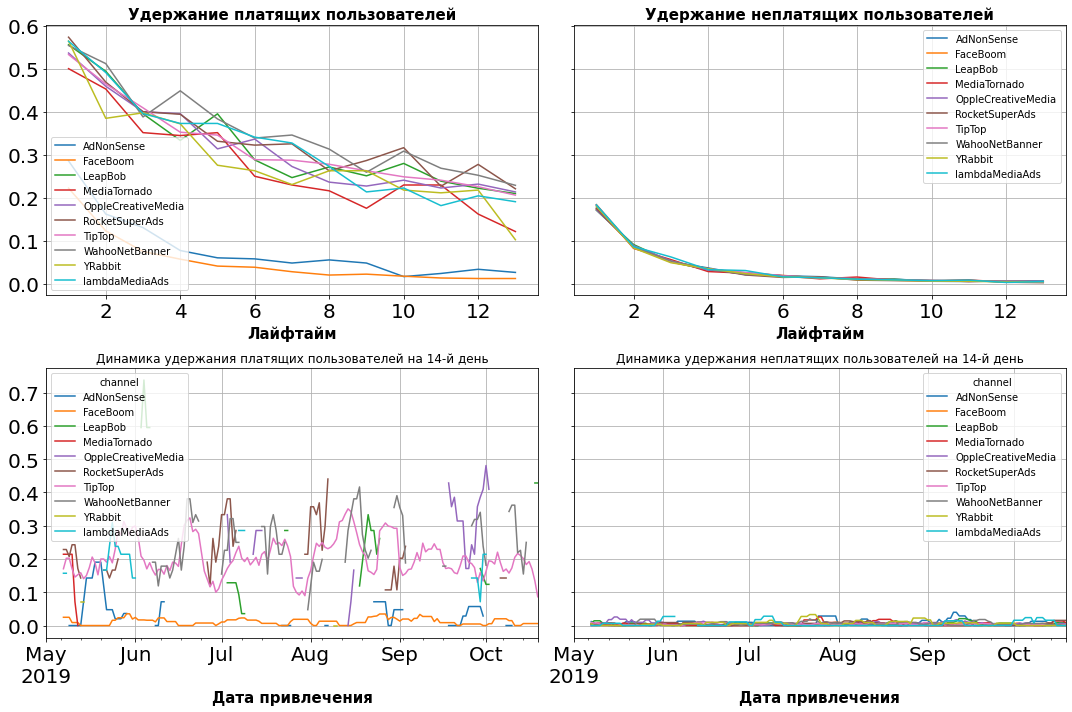

In [44]:
# смотрим конверсию с разбивкой по каналам
dimensions = ['channel']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

# смотрим удержание с разбивкой по каналам
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions)

plot_retention(retention_grouped, retention_history, horizon_days) 

На графике динамики удержания платящих пользователей по каналам мы видим рваные линии. Это говорит о недостаточности данных.<br>
Посмотрим что получится при разбивке по странам и устройствам.<br>
Так же из графиков удержания и динамики удержания можно отметить у канала FaceBoom более низкие уровни. А конверсия выше остальных каналов.

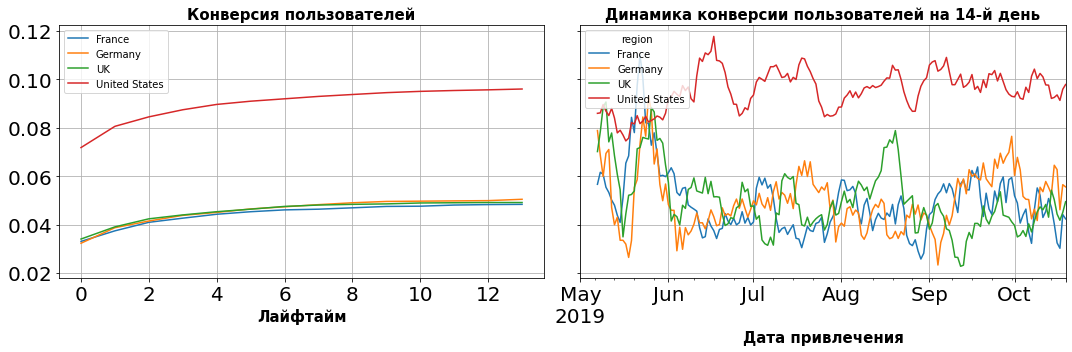

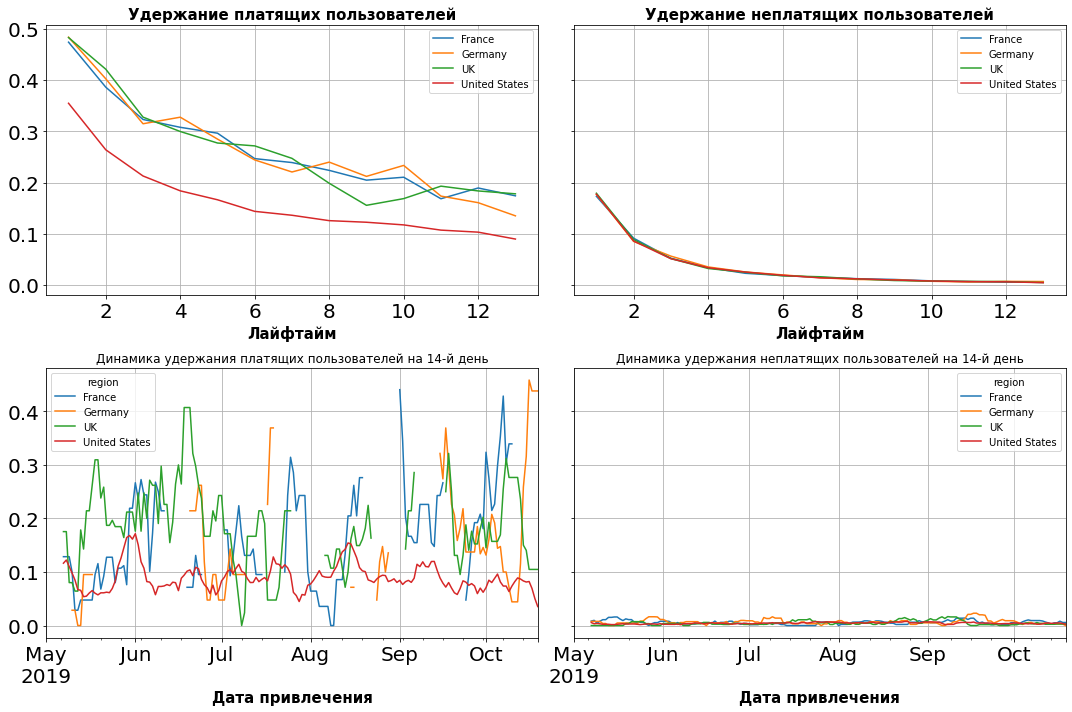

In [45]:
# смотрим конверсию с разбивкой по странам
dimensions = ['region']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

# смотрим удержание с разбивкой по странам
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions)

plot_retention(retention_grouped, retention_history, horizon_days) 

На графике динамики удержания платящих пользователей по странам мы видим рваные линии. Это так же говорит о недостаточности данных.<br>
Посмотрим что получится при разбивке по устройствам.<br>
Конверсия у пользователей из Америки выше, а динамика удержания ниже.

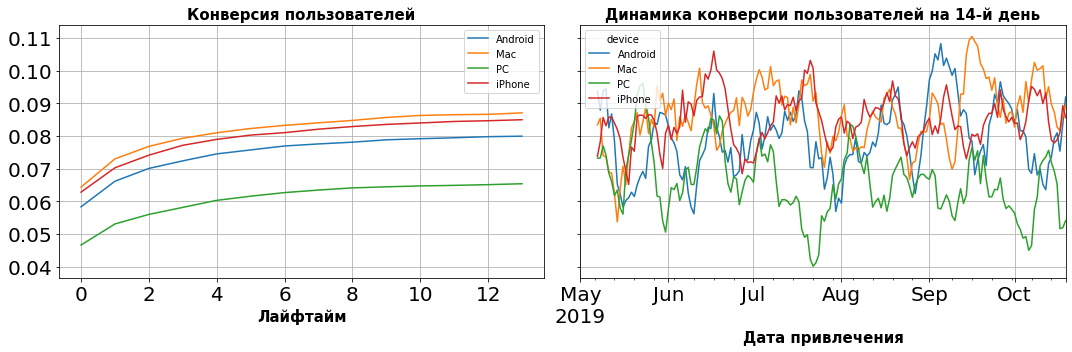

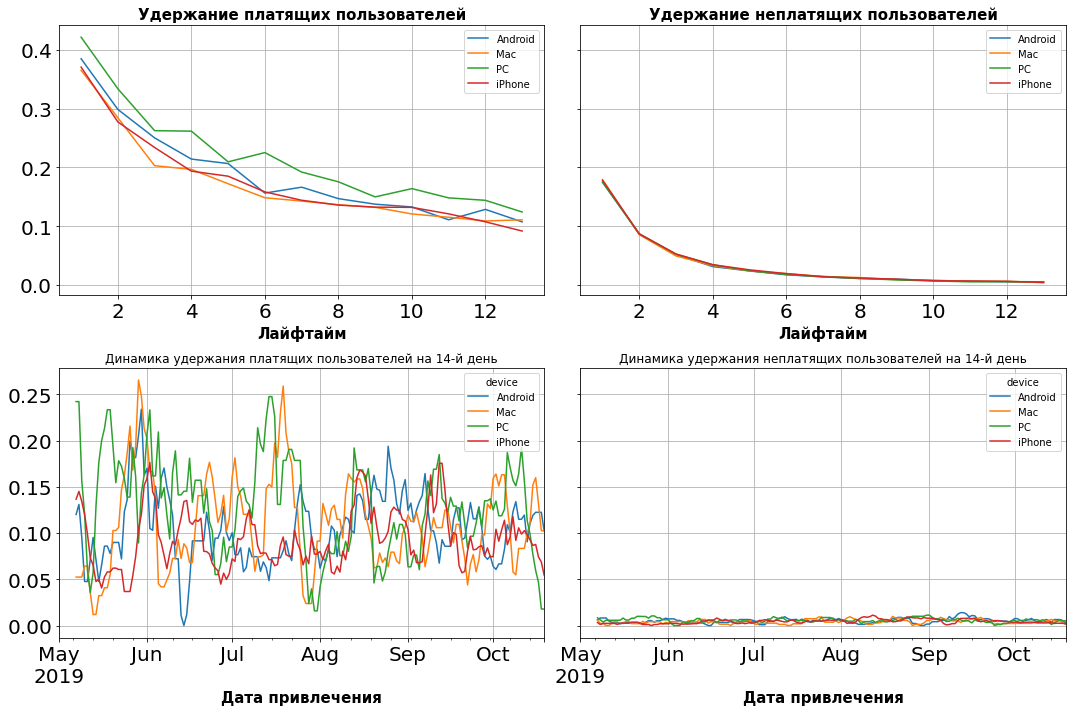

In [46]:
# смотрим конверсию с разбивкой по устройствам
dimensions = ['device']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    profiles, orders, observation_date, horizon_days, dimensions=dimensions)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

# смотрим удержание с разбивкой по устройствам
retention_raw, retention_grouped, retention_history = get_retention(
    profiles, visits, observation_date, horizon_days, dimensions=dimensions)

plot_retention(retention_grouped, retention_history, horizon_days) 

Конверсия пользователей с РС заметно ниже остальных устройств. А удержание выше.

### Анализ пользователей из США, как пользователей из самого крупного региона.

Необходимо построить для Америки с разбивкой по каналам графики: LTV, ROI, удержание, конверсию. И выделить перспективный канал.

In [34]:
# выделение профилей пользователей из США
us_profiles = profiles[profiles['region'] == 'United States']

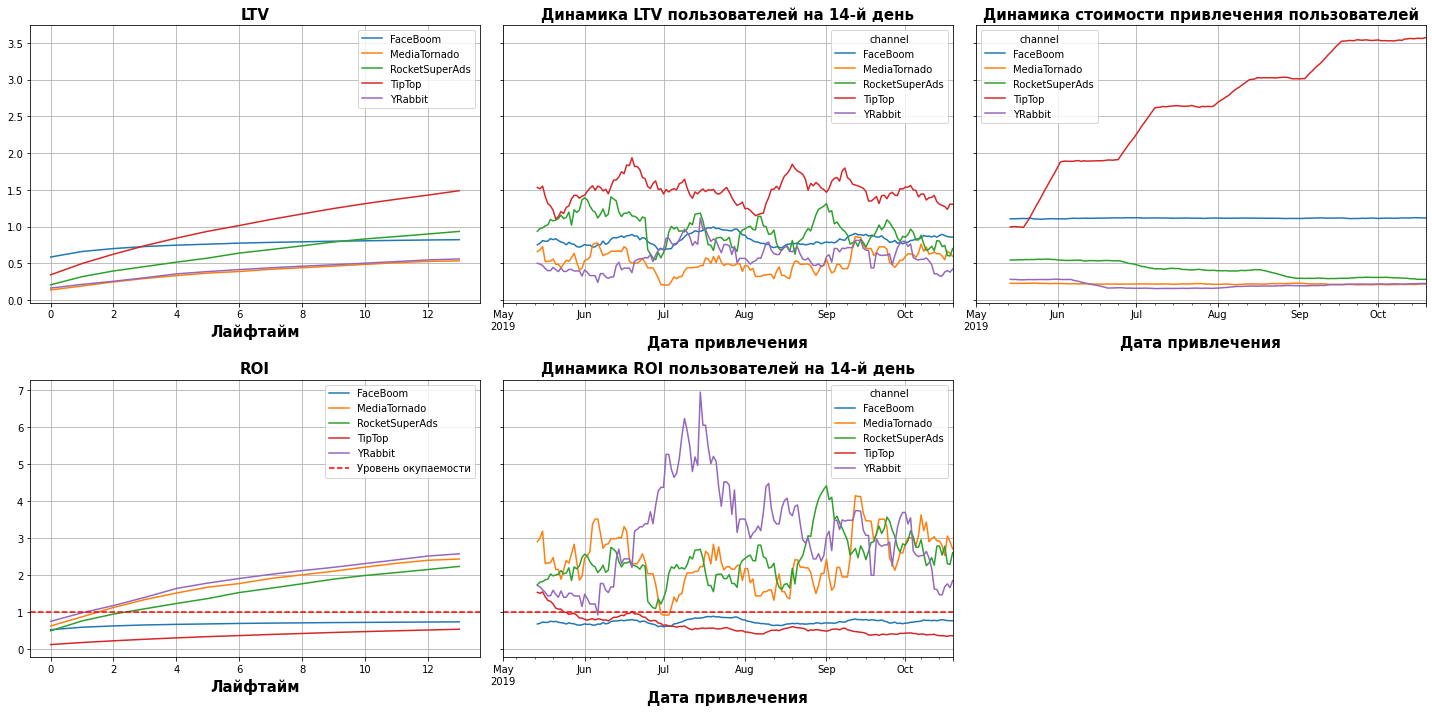

In [35]:
# смотрим окупаемость в США с разбивкой по каналам
dimensions = ['channel']

ltv_raw, ltv_grouped, ltv_history, roi_grouped, roi_history = get_ltv(
    us_profiles, orders, observation_date, horizon_days, dimensions=dimensions)

plot_ltv_roi(ltv_grouped, ltv_history, roi_grouped, roi_history, horizon_days, window=14) 

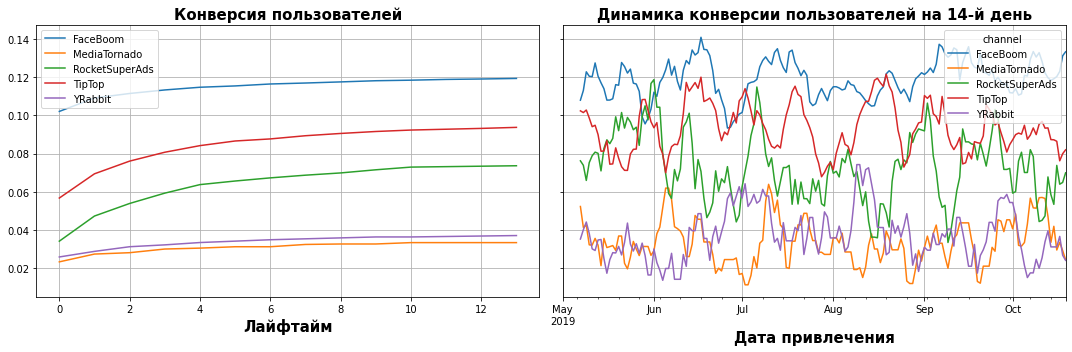

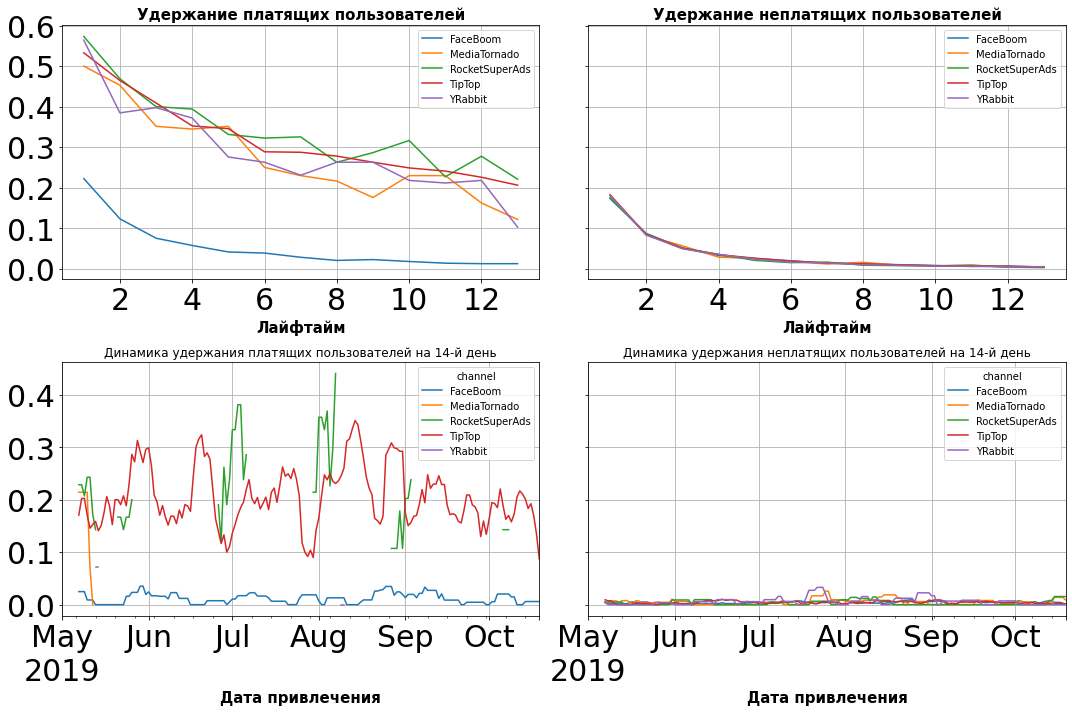

In [36]:
# смотрим конверсию в США с разбивкой по каналам
dimensions = ['channel']

conversion_raw, conversion_grouped, conversion_history = get_conversion(
    us_profiles, orders, observation_date, horizon_days, dimensions=dimensions)

plot_conversion(conversion_grouped, conversion_history, horizon_days) 

# смотрим удержание в США с разбивкой по каналам
retention_raw, retention_grouped, retention_history = get_retention(
    us_profiles, visits, observation_date, horizon_days, dimensions=dimensions)

plot_retention(retention_grouped, retention_history, horizon_days) 

Не смотря на самый высокий LTV у TipTop и FaceBoom, ROI этих каналов ниже уровня окупаемости.<br>
Три других канала имеют ROI выше уровня окупаемости на 1-3-й день. Динамика стоимости привлечения пользователей по ним существенно ниже.<br>
Конверсия самая большая у TipTop и FaceBoom. Конверсия RocketSuperAds на третьем месте.<br>
Удержание пользователей у FaceBoom хуже всех. Остальные каналы идут примерно вровень плюс минус. <br>
По графику динамики удержания платящих пользователей видно, что не хватает данных по пользователям YRabbit, MediaTornado и RocketSuperAds. <br>

## Шаг 6. Выводы

По полученным данным можно сделать следующие выводы:
- Больше всего пользователей привлечено на территории США - 66% от всего числа пользователей и 77% из тех кто оплатил.
- Больше всего денег пострачено на каналы TipTop и FaceBoom. 51% и 30% соответственно.
- Мас и Айфон не окупаются за 14 дней.
- Окупаемость источников TipTop и FaceBoom ниже уровня окупаемости.
- Рекламный бюджет за 5 месяцев слит в рекламу с низкой эффективностью.<br>

Отделу маркетинга рекомендуется следующее:<br>
- Сконцентрировать рекламу на пользователей не из США. Там окупаемость рукламы наступает на 2-3-й день.
- Сконцентрироваться на устройствах РС и Android. 
- Отказаться от рекламы в TipTop и FaceBoom.
- Больше вложить в каналы AdNonSense и lambdaMediaAds. Там довольно высокие уровни тех кто совершил покупку.

Для региона США сделать больше упор на каналы YRabbit, MediaTornado и RocketSuperAds. Причем больше обратить внимание на RocketSuperAds. Его показатели лучше чем у двух других.